In [1]:

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.experimentclasses.RigidEthanolPCA import RigidEthanolPCA
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell

#set parameters
n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 0.05 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/rigidethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

src = workingdirectory + '/codes/experiments/rigidethanol_032520_nsel100_nreps5_var0.py'
filenamescript = folder + '/script.py'
copyfile(src, filenamescript)

new_MN = True
new_grad = True
savename = 'rigidethanol_032520'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_032520'
if new_MN == True:
    experiment = RigidEthanolPCA(dim, cor, var, ii, jj, cores, False, atoms4)
    experiment.M, experiment.Mpca, projector = experiment.generate_data(noise=True)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)
    # with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
    #          'wb') as output:
    #      pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)


/Users/samsonkoelle/manifoldflasso_jmlr


In [5]:

atoms4,p = get_atoms_4(natoms,ii,jj)
experiment.p = p
experiment.atoms4 = atoms4
experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
nreps = 2
selected_points_save = np.zeros((nreps,nsel))
for i in range(nreps):
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
    replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
    replicates[i].coeff_dict = {}
    replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
    replicates[i].combined_norms = {}
    replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
    replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
    replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)
    #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/autograd/tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.01171875
9 0.017578125
10 0.0087890625
11 0.01318359375
12 0.019775390625
13 0.0098876953125
14 0.01483154296875
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
we did it


(12,)
(16,)


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


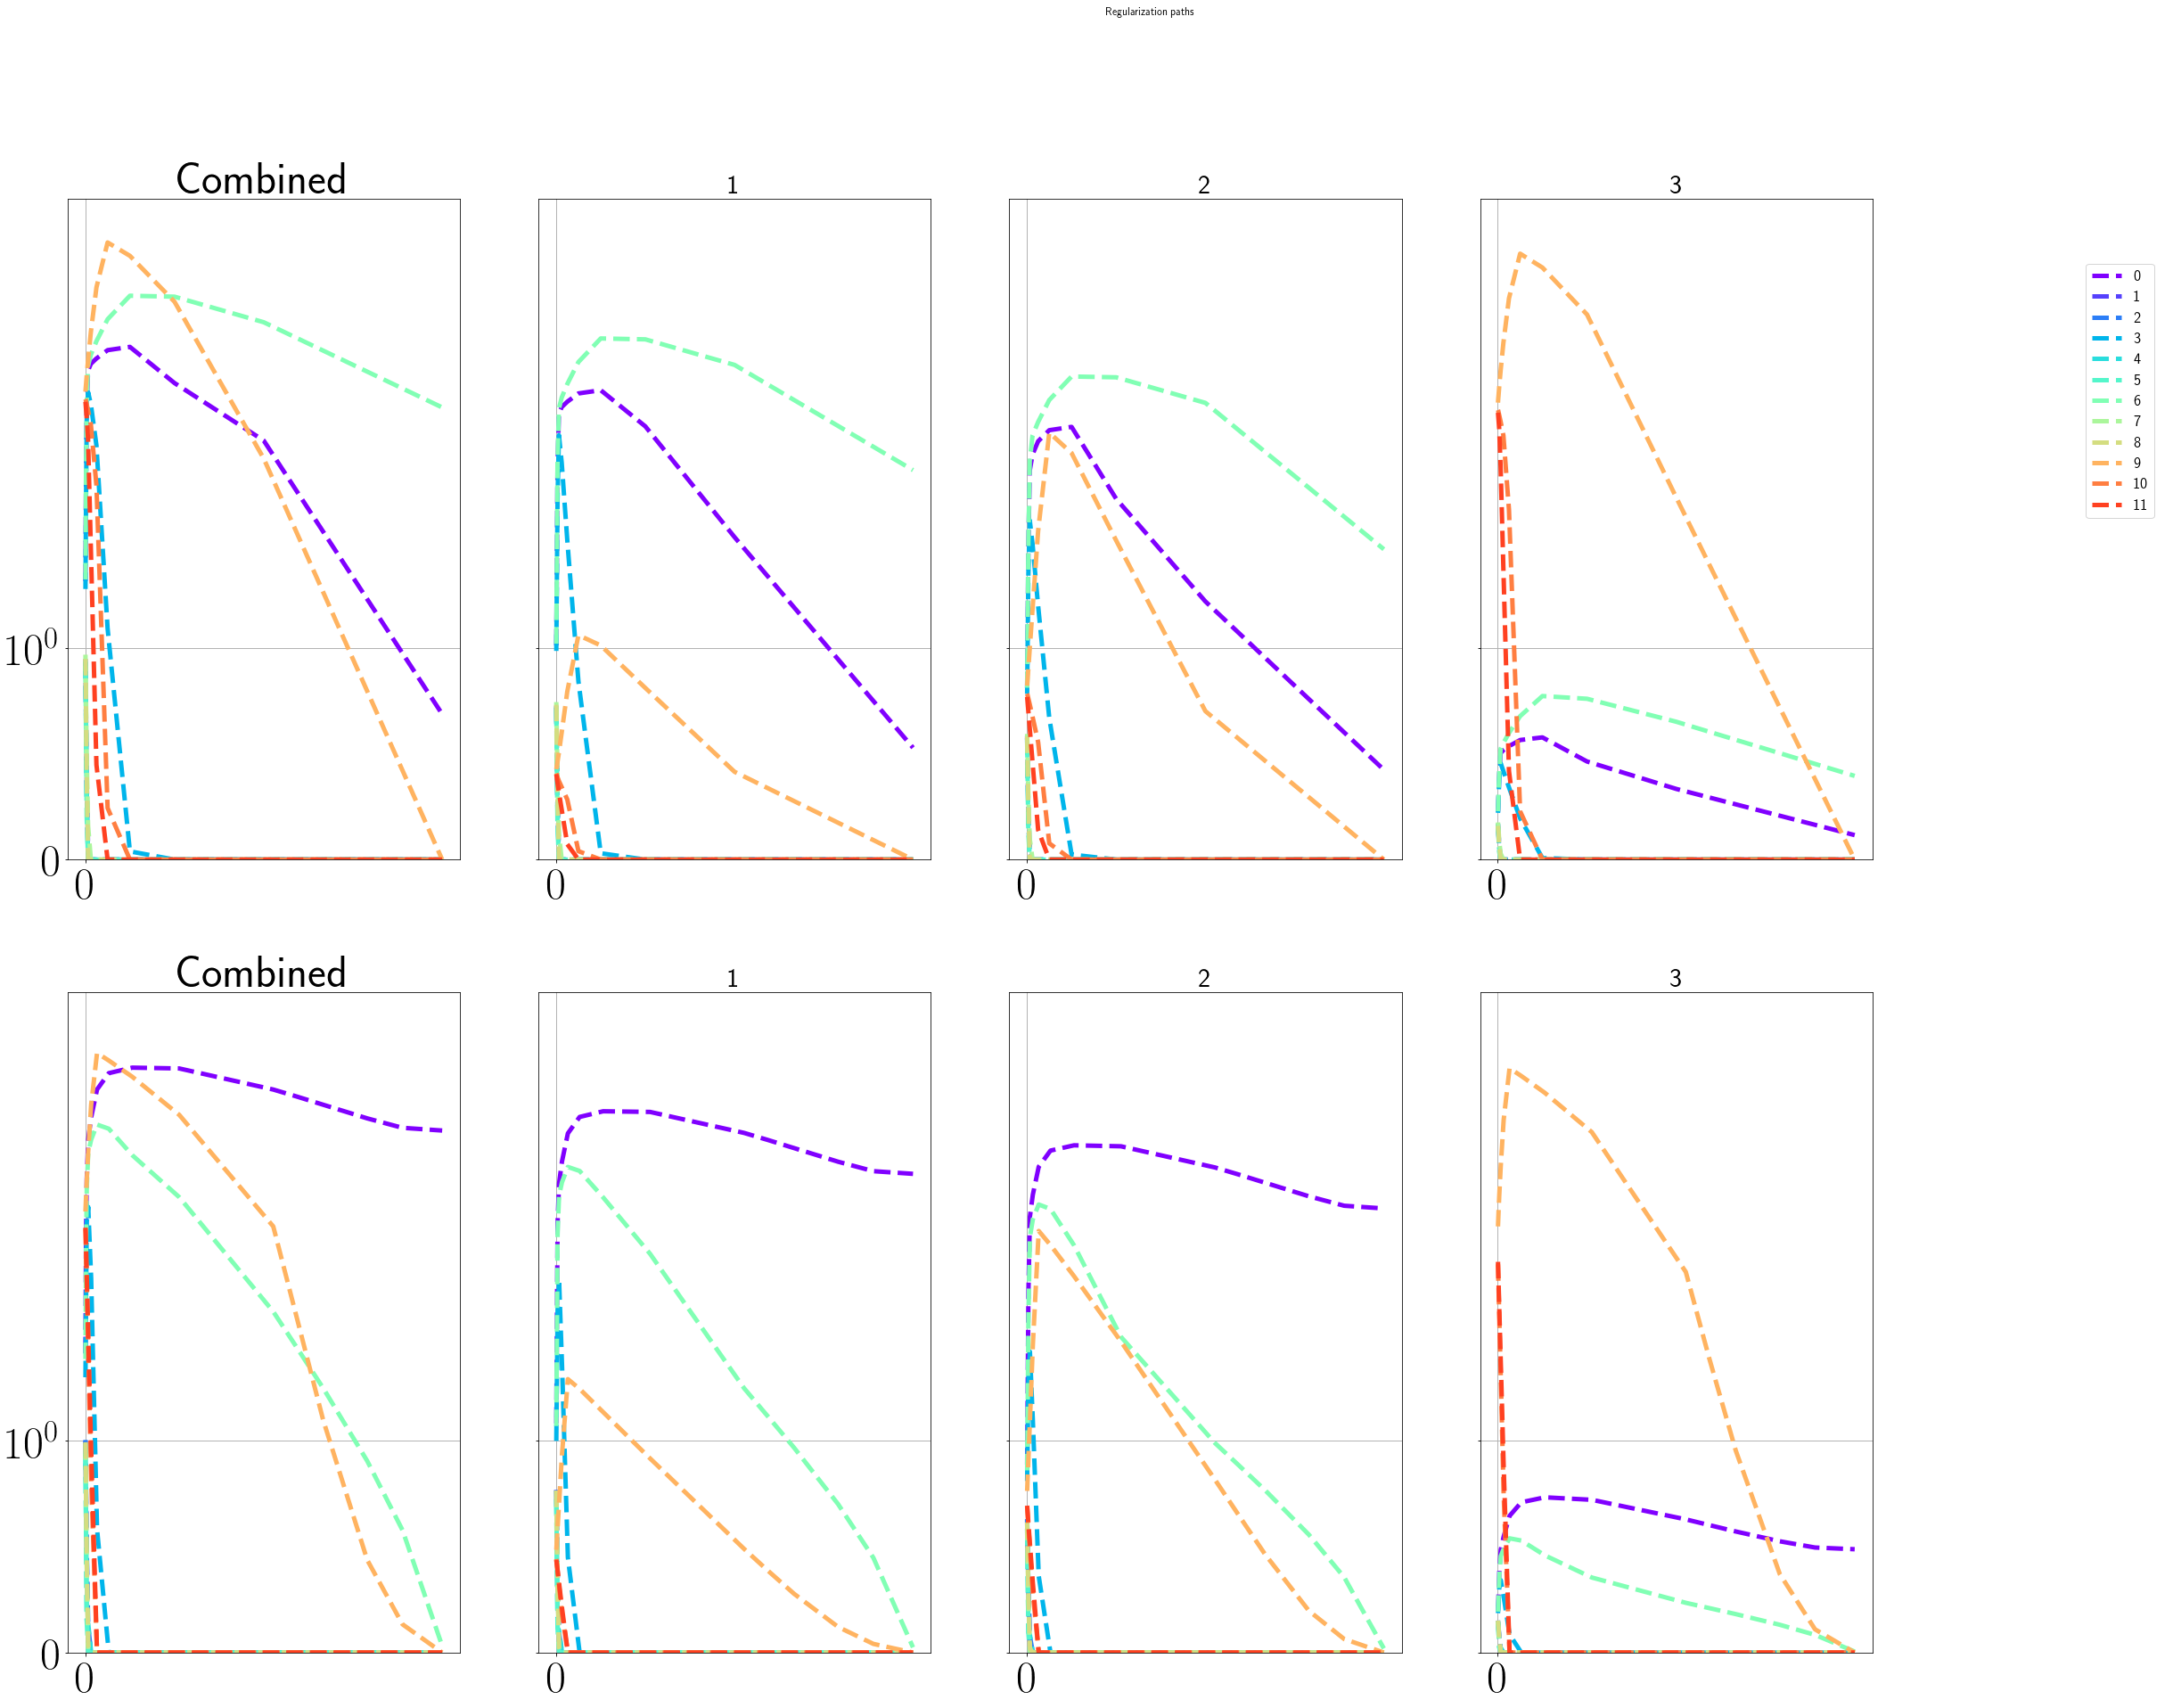

In [7]:
%matplotlib inline
fig, axes_all = plt.subplots(nreps, m + 1,figsize=(15 * m, 15*nreps))
fig.suptitle('Regularization paths')
for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)
    plot_reg_path_ax_lambdasearch(axes_all[i], replicates[i].coeffs, replicates[i].lambdas_plot * np.sqrt(m * nsel), fig)


In [8]:
    coeffs = replicates[0].coeffs
    selected_functions = np.asarray(np.where(np.sum(np.sum(coeffs ** 2, axis=1), axis=1) > 0))

    sls = np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0]
    if len(sls) > 0:
        selection_lambda = np.min(sls)
        selected_functions_at_selection_lambda = selected_functions[1][
            np.where(selected_functions[0] == selection_lambda)[0]]


10.0

In [10]:
sls

array([11])

In [25]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M)
ytrain = experiment.construct_Y_js(replicates[0].df_M)
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.0015*lambdas[selection_lambda]]), 100, 3, itermax, tol)

In [26]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([ 0.19923085,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 19.59697255,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [37]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M[:,[0,6],:])
ytrain = experiment.construct_Y_js(replicates[0].df_M)
outtie = np.linalg.lstsq(xtrain,ytrain)[0]
q = 3
coeffs = np.reshape(outtie, (q, nsel, 2))
experiment.compute_penalty2(np.expand_dims(coeffs,0))
#cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.0015*lambdas[selection_lambda]]), 100, 3, itermax, tol)

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


array([18.85238428])

In [44]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M[:,[0,9],:])
ytrain = experiment.construct_Y_js(replicates[0].df_M)
outtie = np.linalg.lstsq(xtrain,ytrain)[0]
q = 3
coeffs = np.reshape(outtie, (q, nsel, 2))
experiment.compute_penalty2(np.expand_dims(coeffs,0))
#cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.0015*lambdas[selection_lambda]]), 100, 3, itermax, tol)

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.16457294])

In [45]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M[:,:,:])
ytrain = experiment.construct_Y_js(replicates[0].df_M)
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.000001]), 100, 3, itermax, tol)
#coeffs = np.reshape(outtie, (q, nsel, 2))
experiment.compute_penalty2(cs)


array([0.17274395])

In [46]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M[:,:,:])
ytrain = experiment.construct_Y_js(replicates[0].df_M)
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.00000001]), 100, 3, 10*itermax, .01*tol)
#coeffs = np.reshape(outtie, (q, nsel, 2))
experiment.compute_penalty2(cs)


array([0.17300732])

In [48]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M[:,:,:])
ytrain = experiment.construct_Y_js(replicates[0].df_M)
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.00000001]), 100, 3, 10*itermax, .01*tol)
#coeffs = np.reshape(outtie, (q, nsel, 2))
experiment.compute_penalty2(cs)


array([0.17301565])

In [49]:
experiment.get_l2loss(cs, ytrain,xtrain)

array([7.67584261e-15])

In [53]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M[:,:,:])
ytrain = experiment.construct_Y_js(replicates[0].df_M)
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.00001]), 100, 3, 10*itermax, .01*tol)
#coeffs = np.reshape(outtie, (q, nsel, 2))
print(experiment.compute_penalty2(cs))
print(experiment.get_l2loss(cs, ytrain,xtrain))

[0.16403472]
[6.06664586e-10]


In [55]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([7.02447444e+01, 0.00000000e+00, 0.00000000e+00, 7.71050454e-01,
       0.00000000e+00, 0.00000000e+00, 1.75678606e+02, 0.00000000e+00,
       0.00000000e+00, 1.71014060e+03, 1.42470149e-01, 6.85818581e-14])

In [54]:
xtrain,groups = experiment.construct_X_js(replicates[0].dg_M[:,[0,9],:])
ytrain = experiment.construct_Y_js(replicates[0].df_M)
outtie = np.linalg.lstsq(xtrain,ytrain)[0]
q = 3
coeffs = np.reshape(outtie, (q, nsel, 2))
print(experiment.compute_penalty2(np.expand_dims(coeffs,0)))
print(experiment.get_l2loss(np.expand_dims(coeffs,0), ytrain,xtrain))
#cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.0015*lambdas[selection_lambda]]), 100, 3, itermax, tol)

[0.16457294]
[4.68317246e-34]


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
    def construct_Y(self, df_M):
        """ df_M should have shape n x dim x dim
        """
        n = df_M.shape[0]
        dim = df_M.shape[1]

        #reorg1 = np.swapaxes(df_M, 0, 1)
        yvec = np.reshape(df_M, (n * dim * dim))
        return (yvec)

In [57]:
Xtest = np.asarray([[[1,0],[1,0.1],[0,.5]]])#.5]]])
xtrain,groups = experiment.construct_X(Xtest)
ytrain = construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = 1))

In [69]:
cls = np.expand_dims(np.reshape(np.linalg.lstsq(xtrain[:,[0,2,3,5]], ytrain)[0], [2,1,2]),0)

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [61]:
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.0001]), 1, 2, itermax, tol)

In [62]:
experiment.compute_penalty2(cs)

array([2.99687483])

In [70]:
experiment.compute_penalty2(cls)

array([3.])

In [71]:
cs

array([[[[ 0.53101885,  0.46888137, -0.09375767]],

        [[-0.05904424,  0.05905355,  1.98778808]]]])

In [ ]:

atoms4,p = get_atoms_4(natoms,ii,jj)
experiment.p = p
experiment.atoms4 = atoms4
experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))
for i in range(nreps):
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
    replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
    replicates[i].coeff_dict = {}
    replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
    replicates[i].combined_norms = {}
    replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
    replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
    replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)
    #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)


fig, axes_all = plt.subplots(nreps, m + 1,figsize=(15 * m, 15*nreps))
fig.suptitle('Regularization paths')
for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)
    plot_reg_path_ax_lambdasearch(axes_all[i], replicates[i].coeffs, replicates[i].lambdas_plot * np.sqrt(m * nsel), fig)
fig.savefig(folder + '/beta_paths')

supports = {}
for i in range(nreps):
    supports[i] = get_support(replicates[i].coeffs, dim)

fig, ax = plt.subplots(1, figsize=(15 , 15 ))
plot_support_2d(supports, experiment.p)
fig.savefig(folder + '/flasso_support')

fig, axes_all = plt.subplots(nreps,figsize=(15*nreps,15))
fig.suptitle('Cosines for each replicate')
for i in range(nreps):
    full = np.concatenate([replicates[i].dg_M, np.swapaxes(replicates[i].df_M,1,2)],1)
    asdf = get_cosines(full)
    axes_all[i].imshow(asdf)
fig.savefig(folder + '/cosines')

ols_norm, supports_brute = get_olsnorm_and_supportsbrute(experiment,replicates)


fig, axes_all = plt.subplots(nreps,figsize=(15*nreps,15))
fig.suptitle('GL norm for different OLS solutions')
for r in range(nreps):
    axes_all[r].imshow(np.log(ols_norm[r]))
    highlight_cell(supports_brute[r][1],supports_brute[r][0],color="limegreen", linewidth=3,ax=axes_all[r])
    highlight_cell(supports_brute[r][0],supports_brute[r][1],color="limegreen", linewidth=3,ax=axes_all[r])
fig.savefig(folder + '/olsnorms')

fig, ax = plt.subplots(1, figsize=(15 , 15 ))
plot_support_2d(supports_brute, experiment.p)
fig.savefig(folder + '/ols_supports')
plt.close()

fig, axes = plt.subplots(nreps, p, figsize=(15 * p, 15 * nreps))
plot_gs_v_dgnorm(experiment,replicates,axes)
fig.savefig(folder + '/gs_v_dgnorm.png')

plot_dot_distributions(experiment,replicates)
#fig.savefig(folder + '/dotdistribution.png')

